In [1]:
import pandas as pd
import time
import math
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import pickle
import sys

"""
Some global parameters to be tuned here.
"""
date_range = ("2016-01-01T00:00:00", "2016-03-31T23:59:59")

time_start = int(time.mktime(time.strptime(date_range[0], '%Y-%m-%dT%H:%M:%S')))
time_end = int(time.mktime(time.strptime(date_range[1], '%Y-%m-%dT%H:%M:%S')))

# TODO: def foo()
# 7 days as a period
period = 604800.0
n_period = int(math.ceil((time_end - time_start)/(period)))



def save_obj(obj, name):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

def time_str2int(in_time):
    return int(time.mktime(time.strptime(in_time, '%Y-%m-%d %H:%M:%S'))) 

def string2list(in_str):
    ret = in_str.split('],[')
    temp = []
    for each in ret:
        temp.append(each.strip('[').strip(']').split(','))
    return temp
    #return pd.DataFrame(temp)


def get_eventids(filename):
    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    grouped_by_eventid = data_all.groupby([1])
    eventids = grouped_by_eventid.groups.keys()
    return eventids


def get_uid2uuid(userbase_dataframe, uuid_list):
    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
    uid2uuid = {}
    for each in u_by_uuid.iterrows():
        if each[1][0] not in uid2uuid:
            uid2uuid[each[1][0]] = []
        uid2uuid[each[1][0]].append(each[1][1])
    return uid2uuid

def feature_expenditure(filename, userbase_dataframe, uuid_list):

    uid2uuid = get_uid2uuid(userbase_dataframe, uuid_list)
    for each in uid2uuid:
        if len(uid2uuid[each]) > 1:
            print "Found one-to-many uid to uuid relationship, but I ignored it for simplicity."

    e = pd.read_csv(filename, sep='\t', header = None)
    exp = e[e[0].isin(set(uid2uuid.keys()))]
    exp[-1] = exp[0].map(lambda x: uid2uuid[x][0])
    exp_by_uuid = exp.groupby([-1])

    expenditure_dict = {}
    for each in exp_by_uuid.groups:
        index_list = exp_by_uuid.groups[each]
        data_frame = exp.loc[index_list]
        
        reg = []
        rec = []
        pay = []
        for row in data_frame.iterrows():
            reg += string2list(row[1][1])
            rec += string2list(row[1][2])
            pay += string2list(row[1][3])
        reg = pd.DataFrame(reg)
        rec = pd.DataFrame(rec)
        pay = pd.DataFrame(pay)
        
        
        """reg"""
        reg = reg[reg[3]!='0']
        try: # no reg means no rec or pay
            #[0] #uid
            temp = [len(index_list)]
            #[1] #games
            temp.append(len(reg[0]))
            #[2] # unique games
            temp.append(len(reg[1].unique()))
            #[3] # unique cid
            temp.append(len(reg[2].unique()))
            #[4] # unique game_uid
            temp.append(len(reg[4].unique()))
            #[5] # unique ucid
            temp.append(len(reg[5].unique()))

            reg_time = reg[3].map(time_str2int)
            #[6] max reg time
            temp.append(max(reg_time))
            #[7] min reg time
            temp.append(min(reg_time))
            #[8] reg time span
            temp.append(max(reg_time) - min(reg_time))
            #[9] reg time mean
            temp.append(reg_time.mean())
            #[10] reg time mid
            temp.append(reg_time.quantile(0.5))
            #[11] reg time std
            temp.append(np.std(reg_time))
        except:
            continue
        
        """rec"""
        rec = rec[rec[2]!='0']
        if len(rec) == 0:
            temp += [np.nan] * 12
        else:
            #[12] # rec
            temp.append(len(rec[0]))
            #[13] # unique games
            temp.append(len(rec[0].unique()))
            #[14] # unique types
            temp.append(len(rec[1].unique()))
            #[15] # unique cid
            temp.append(len(rec[3].unique()))
            #[16] # unique item
            temp.append(len(rec[4].unique()))    
            #[17] # unique appid
            temp.append(len(rec[5].unique()))  
            #[18] # unique pay_from
            temp.append(len(rec[6].unique()))  

            rec_time = rec[2].map(time_str2int)
            #[19] max reg time
            temp.append(max(rec_time))
            #[20] min reg time
            temp.append(min(rec_time))
            #[21] reg time span
            temp.append(max(rec_time) - min(rec_time))
            #[21] reg time mean
            temp.append(rec_time.mean())
            #[22] reg time mid
            temp.append(rec_time.quantile(0.5))
            #[23] reg time std
            temp.append(np.std(rec_time))
        
        pay = pay[pay[2]!='0']
        if len(pay) == 0:
            temp += [np.nan] * 11
        else:
            #[24] # payments
            temp.append(len(pay[0]))
            #[25] # unique games
            temp.append(len(pay[0].unique()))
            #[26] # unique cid
            temp.append(len(pay[1].unique()))
            #[27] # unique appid
            temp.append(len(pay[3].unique()))
            #[28] # unique item
            temp.append(len(pay[4].unique()))    
            #[29] # unique porder
            temp.append(len(pay[5].unique()))  


            pay_time = pay[2].map(time_str2int)
            #[30] max reg time
            temp.append(max(pay_time))
            #[31] min reg time
            temp.append(min(pay_time))
            #[32] reg time span
            temp.append(max(pay_time) - min(pay_time))
            #[33] reg time mean
            temp.append(pay_time.mean(0.5))
            #[34] reg time mid
            temp.append(pay_time.quantile(0.5))
            #[33] reg time std
            temp.append(np.std(pay_time))
        
        expenditure_dict[each] = temp

    return expenditure_dict  


def cleaning_filter(input_element, filter_list, replacement):
    if input_element not in filter_list:
        return replacement
    return input_element

def ucid_cleaner(input_element):
    try:
        ret = eval(input_element)
    except:
        ret = []
    if type(ret) is list:
        return ret
    elif type(ret) is dict:
        return map(lambda x: int(x), ret.values())
    elif type(ret) is int:
        return [ret]
    else:
        print "Error in ucid_cleaner"

def feature_userbase(userbase_dataframe, uuid_list):
    """
    Input: userbase_dataframe-- stacked userbases by pandas.read_csv()
           uuid_list-- -- uuids to be extracted from userbase

    Output: a dictionary of (uuid, feature) pairs
    """

    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    # remove empty uuids: 'cfcd208495d565ef66e7dff9f98764da' 
    u_by_uuid = u_by_uuid[u_by_uuid[1] != 'cfcd208495d565ef66e7dff9f98764da']
    # remove NaNs
    u_by_uuid.drop(u_by_uuid[u_by_uuid[9].isnull()].index, inplace=True)

    """Some data cleaning"""
    # clean sex
    value_counts = u_by_uuid[5].value_counts()
    u_by_uuid[5] = u_by_uuid[5].map(lambda x: cleaning_filter(x, value_counts.index[:4], value_counts.index[0]))

    # clean platform
    u_by_uuid[6] = u_by_uuid[6].map(lambda x: str(x))
    value_counts = u_by_uuid[6].value_counts()
    u_by_uuid[6] = u_by_uuid[6].map(lambda x: cleaning_filter(x, value_counts.index[:3], '0'))

    # clean status
    u_by_uuid[7] = u_by_uuid[7].map(lambda x: str(x))
    u_by_uuid[7] = u_by_uuid[7].map(lambda x: cleaning_filter(x, ['0'], '1'))

    # clean ucid
    u_by_uuid[8] = u_by_uuid[8].map(lambda x: str(x))

    """some processing about ucid"""
    # clean ucid
    u_by_uuid[10] = u_by_uuid[10].map(ucid_cleaner)
    ucids = []
    for each in u_by_uuid[10]:
        ucids += each
    dictinct_ucids = list(set(ucids))

    # Begin feature engineering
    grouped_by_u = u_by_uuid.groupby([1])
    
    userbase_dict = {}
    for each in grouped_by_u.groups:
        
        index_list = grouped_by_u.groups[each]
        data_frame = u_by_uuid.loc[index_list]
        
        try:
            #[0] uid
            temp = [len(index_list)]

            #[1] reg_ip
            temp.append(data_frame[2].nunique())

            #[2] has signature or not
            temp.append(int(sum(data_frame[3].isnull()) > 0))


            #[3] has nickname or not
            #nn = data_frame['4'].map(lambda x: x == 'None')
            temp.append(int(sum(data_frame[4].map(lambda x: x == 'None')) > 0))

            #[4] sex majority -- One-Hot?
            temp.append(str(data_frame[5].value_counts().index[0]))
            #[5] sex unique count
            temp.append(data_frame[5].nunique())

            #[6] platform majority -- One-Hot ?
            temp.append(str(data_frame[6].value_counts().index[0]))
            #[7] platform unique count
            temp.append(data_frame[6].nunique())

            #[8] ucid majority -- One-hot ?
            temp.append(str(data_frame[8].value_counts().index[0]))
            #[9] ucid unique count
            temp.append(data_frame[8].nunique())

            #reg time stuff
            reg_time = data_frame[9].map(time_str2int)
            #[10] reg time max
            temp.append(max(reg_time))
            #[11] reg time min
            temp.append(min(reg_time))
            #[12] reg time span
            temp.append(max(reg_time) - min(reg_time))
            #[13] reg time mean
            temp.append(reg_time.mean())
            #[14] reg time mid
            temp.append(reg_time.quantile(0.5))
            #[15] reg time std
            temp.append(np.std(reg_time))


            #[16] group: number of groups
            temp.append(sum(data_frame[10].map(lambda x: len(x))) )
            #[17] group: dummy
            temp.append(int(temp[len(temp)-1] > 0))

            """TODO: a huge feature line of ucid down in the bottom"""

            #[18] name
            temp.append(int(sum(data_frame[11].map(lambda x: x != 'None')) > 0))

            #[19-25] dummy
            for i in range(12, 19):
                temp.append(int(sum(data_frame[i]) > 0))

            """the huge line promised above"""
            df_ucids = []
            for ucid_list in data_frame[10]:
                df_ucids += ucid_list
            ucid_feature = [0] * len(dictinct_ucids)
            for i, e in enumerate(dictinct_ucids):
                if e in df_ucids:
                    ucid_feature[i] += 1

            temp += ucid_feature

            userbase_dict[each] = temp

        except:
            e = sys.exc_info()[0]
            print data_frame
            print e
            break

    return userbase_dict


def feature_event(filename):

    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    # binning whole logs in periods as a big dict()
    whole_dict = {i : {} for i in range(n_period)}
    # for each log
    for log in data_all.iterrows():
        # find its binned period
        idx = int(math.floor((log[1][2] - time_start)/period))

        if log[1][0] not in whole_dict[idx]:
            whole_dict[idx][log[1][0]] = []

        # append uuid, event id, and timestamp to the list
        whole_dict[idx][log[1][0]].append((log[1][1], log[1][2]))

    return whole_dict

def get_labels(whole_dict):

    # creating labels for churn = 1, stay = 0
    labels = {i : {} for i in range(n_period)}
    #for each period
    for i in range(n_period - 1):
        # for each uuid
        for uuid in whole_dict[i]:
            # check if the uuid appears in the next period, if yes-> stay; no-> churn
            if uuid in whole_dict[i + 1]:
                labels[i][uuid] = 0
            else:
                labels[i][uuid] = 1

    return labels

In [77]:
u0 = pd.read_csv("/data/yulun/timeline/user_base_0.txt", sep='\t', header = None)
u1 = pd.read_csv("/data/yulun/timeline/user_base_1.txt", sep='\t', header = None)
u2 = pd.read_csv("/data/yulun/timeline/user_base_2.txt", sep='\t', header = None)
u3 = pd.read_csv("/data/yulun/timeline/user_base_3.txt", sep='\t', header = None)
u4 = pd.read_csv("/data/yulun/timeline/user_base_4.txt", sep='\t', header = None)
u5 = pd.read_csv("/data/yulun/timeline/user_base_5.txt", sep='\t', header = None)
u6 = pd.read_csv("/data/yulun/timeline/user_base_6.txt", sep='\t', header = None)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
u = u0.append(u1).append(u2).append(u3).append(u4).append(u5).append(u6)

In [80]:
def get_uuids(filename):
    # Get logs within the time range
    t = pd.read_csv(filename, sep='\t', header = None)
    t1 = t[t[2] >= time_start]
    data_all = t1[t1[2] <= time_end]

    grouped_by_uuid = data_all.groupby([0])
    uuids = grouped_by_uuid.groups.keys()

    return uuids

In [81]:
uuid_list = get_uuids("/data/yulun/timeline/timeline_event_gpapp.txt")

In [17]:
userbase_dict = feature_userbase(u, uuid_list)

In [18]:
save_obj(userbase_dict, 'userbase_dict_3')

In [19]:
def get_uuid2uid(userbase_dataframe, uuid_list):
    # TODO
    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
    uuid2uid = {}
    for each in u_by_uuid.iterrows():
        if each[1][1] not in uuid2uid:
            uuid2uid[each[1][1]] = []
        uuid2uid[each[1][1]].append(each[1][0])
    return uuid2uid

def get_uid2uuid(userbase_dataframe, uuid_list):
    u_by_uuid = userbase_dataframe[userbase_dataframe[1].isin(set(uuid_list))]
    u_by_uuid = u_by_uuid[u_by_uuid[1]!= 'cfcd208495d565ef66e7dff9f98764da']
    uid2uuid = {}
    for each in u_by_uuid.iterrows():
        if each[1][0] not in uid2uuid:
            uid2uuid[each[1][0]] = []
        uid2uuid[each[1][0]].append(each[1][1])
    return uid2uuid

In [20]:
uuid2uid = get_uuid2uid(u, uuid_list)

In [31]:
uid2uuid = get_uid2uuid(u, uuid_list)

In [32]:
    for each in uid2uuid:
        if len(uid2uuid[each]) > 1:
            print "Found one-to-many uid to uuid relationship, but I ignored it for simplicity."

In [35]:
e = pd.read_csv('/data/yulun/timeline/expenditure_timeline.txt', sep='\t', header = None)
exp = e[e[0].isin(set(uid2uuid.keys()))]
exp[-1] = exp[0].map(lambda x: uid2uuid[x][0])
exp_by_uuid = exp.groupby([-1])

expenditure_dict = {}
for each in exp_by_uuid.groups:
    index_list = exp_by_uuid.groups[each]
    data_frame = exp.loc[index_list]

    reg = []
    rec = []
    pay = []
    for row in data_frame.iterrows():
        reg += string2list(row[1][1])
        rec += string2list(row[1][2])
        pay += string2list(row[1][3])
    reg = pd.DataFrame(reg)
    rec = pd.DataFrame(rec)
    pay = pd.DataFrame(pay)


    """reg"""
    reg = reg[reg[3]!='0']
    try: # no reg means no rec or pay
        #[0] #uid
        temp = [len(index_list)]
        #[1] #games
        temp.append(len(reg[0]))
        #[2] # unique games
        temp.append(len(reg[1].unique()))
        #[3] # unique cid
        temp.append(len(reg[2].unique()))
        #[4] # unique game_uid
        temp.append(len(reg[4].unique()))
        #[5] # unique ucid
        temp.append(len(reg[5].unique()))

        reg_time = reg[3].map(time_str2int)
        #[6] max reg time
        temp.append(max(reg_time))
        #[7] min reg time
        temp.append(min(reg_time))
        #[8] reg time span
        temp.append(max(reg_time) - min(reg_time))
        #[9] reg time mean
        temp.append(reg_time.mean())
        #[10] reg time mid
        temp.append(reg_time.quantile(0.5))
        #[11] reg time std
        temp.append(np.std(reg_time))
    except:
        continue

    """rec"""
    rec = rec[rec[2]!='0']
    if len(rec) == 0:
        temp += [np.nan] * 12
    else:
        #[12] # rec
        temp.append(len(rec[0]))
        #[13] # unique games
        temp.append(len(rec[0].unique()))
        #[14] # unique types
        temp.append(len(rec[1].unique()))
        #[15] # unique cid
        temp.append(len(rec[3].unique()))
        #[16] # unique item
        temp.append(len(rec[4].unique()))    
        #[17] # unique appid
        temp.append(len(rec[5].unique()))  
        #[18] # unique pay_from
        temp.append(len(rec[6].unique()))  

        rec_time = rec[2].map(time_str2int)
        #[19] max reg time
        temp.append(max(rec_time))
        #[20] min reg time
        temp.append(min(rec_time))
        #[21] reg time span
        temp.append(max(rec_time) - min(rec_time))
        #[22] reg time mean
        temp.append(rec_time.mean())
        #[23] reg time mid
        temp.append(rec_time.quantile(0.5))
        #[24] reg time std
        temp.append(np.std(rec_time))

    pay = pay[pay[2]!='0']
    if len(pay) == 0:
        temp += [np.nan] * 11
    else:
        #[25] # payments
        temp.append(len(pay[0]))
        #[26] # unique games
        temp.append(len(pay[0].unique()))
        #[27] # unique cid
        temp.append(len(pay[1].unique()))
        #[28] # unique appid
        temp.append(len(pay[3].unique()))
        #[29] # unique item
        temp.append(len(pay[4].unique()))    
        #[30] # unique porder
        temp.append(len(pay[5].unique()))  


        pay_time = pay[2].map(time_str2int)
        #[31] max reg time
        temp.append(max(pay_time))
        #[32] min reg time
        temp.append(min(pay_time))
        #[33] reg time span
        temp.append(max(pay_time) - min(pay_time))
        #[34] reg time mean
        temp.append(pay_time.mean())
        #[35] reg time mid
        temp.append(pay_time.quantile(0.5))
        #[36] reg time std
        temp.append(np.std(pay_time))

    expenditure_dict[each] = temp

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [38]:
save_obj(expenditure_dict, 'expenditure_dict_3')

# Done preprocessing

In [2]:
whole_dict = load_obj('whole_dict_2')

In [3]:
exp_dict = load_obj('expenditure_dict_3')

In [4]:
user_dict = load_obj('userbase_dict_3')

In [5]:
labels = get_labels(whole_dict)

In [6]:
eventids = get_eventids('/data/yulun/timeline/timeline_event_gpapp.txt')

In [7]:
features = []
num_handcraft_feature = 105
for i in range(n_period - 2):
    for uuid in whole_dict[i]:
        e_len = len(eventids)

        row = np.zeros(e_len + num_handcraft_feature)

        # label
        row[0] = labels[i][uuid]

        times = []
        times_diff = []
        for each in whole_dict[i][uuid]:
            eid = each[0]
            ts = each[1]
            idx = eventids.index(eid)
            # [0] - [len(eventid)] event feature
            row[idx + 1] += 1

            times.append(ts)
            times_diff.append(ts - (time_start + period*(i)))

        # add handcraft features here
        """time features"""
        # time
        row[e_len + 1] = max(times)
        row[e_len + 2] = min(times)
        row[e_len + 3] = max(times) - min(times)
        row[e_len + 4] = np.mean(times)
        row[e_len + 5] = np.percentile(times, 50)
        row[e_len + 6] = np.std(times)
        # time_diff
        row[e_len + 7] = max(times_diff)
        row[e_len + 8] = min(times_diff)
        row[e_len + 9] = np.mean(times_diff)
        row[e_len + 10] = np.percentile(times_diff, 50)

        # userbase integrated time features
        try:
            row[e_len + 11] = max(times) - user_dict[uuid][10]
            row[e_len + 12] = max(times) - user_dict[uuid][11]
            row[e_len + 13] = max(times) - user_dict[uuid][13]
            row[e_len + 14] = max(times) - user_dict[uuid][14]
            row[e_len + 15] = min(times) - user_dict[uuid][10]
            row[e_len + 16] = min(times) - user_dict[uuid][11]
            row[e_len + 17] = min(times) - user_dict[uuid][13]
            row[e_len + 18] = min(times) - user_dict[uuid][14]
            row[e_len + 19] = np.percentile(times, 50) - user_dict[uuid][10]
            row[e_len + 20] = np.percentile(times, 50) - user_dict[uuid][11]
            row[e_len + 21] = np.percentile(times, 50) - user_dict[uuid][13]
            row[e_len + 22] = np.percentile(times, 50) - user_dict[uuid][14]
            row[e_len + 23] = np.mean(times) - user_dict[uuid][10]
            row[e_len + 24] = np.mean(times) - user_dict[uuid][11]
            row[e_len + 25] = np.mean(times) - user_dict[uuid][13]
            row[e_len + 26] = np.mean(times) - user_dict[uuid][14]
            row[e_len + 27] = (time_start + period*(i)) - user_dict[uuid][10]
            row[e_len + 28] = (time_start + period*(i)) - user_dict[uuid][11]
            row[e_len + 29] = (time_start + period*(i)) - user_dict[uuid][13]
            row[e_len + 30] = (time_start + period*(i)) - user_dict[uuid][14]
        except:
            row[e_len + 11 : e_len + 31] = np.nan

        # expenditure integrated time features
        try:
            row[e_len + 31] = max(times) - exp_dict[uuid][6]
            row[e_len + 32] = max(times) - exp_dict[uuid][7]
            row[e_len + 33] = max(times) - exp_dict[uuid][9]
            row[e_len + 34] = max(times) - exp_dict[uuid][10]
            row[e_len + 35] = min(times) - exp_dict[uuid][6]
            row[e_len + 36] = min(times) - exp_dict[uuid][7]
            row[e_len + 37] = min(times) - exp_dict[uuid][9]
            row[e_len + 38] = min(times) - exp_dict[uuid][10]
            row[e_len + 39] = np.percentile(times, 50) - exp_dict[uuid][6]
            row[e_len + 40] = np.percentile(times, 50) - exp_dict[uuid][7]
            row[e_len + 41] = np.percentile(times, 50) - exp_dict[uuid][9]
            row[e_len + 42] = np.percentile(times, 50) - exp_dict[uuid][10]
            row[e_len + 43] = np.mean(times) - exp_dict[uuid][6]
            row[e_len + 44] = np.mean(times) - exp_dict[uuid][7]
            row[e_len + 45] = np.mean(times) - exp_dict[uuid][9]
            row[e_len + 46] = np.mean(times) - exp_dict[uuid][10]
            row[e_len + 47] = (time_start + period*(i)) - exp_dict[uuid][6]
            row[e_len + 48] = (time_start + period*(i)) - exp_dict[uuid][7]
            row[e_len + 49] = (time_start + period*(i)) - exp_dict[uuid][9]
            row[e_len + 50] = (time_start + period*(i)) - exp_dict[uuid][10]
        except:
            row[e_len + 31 : e_len + 51] = np.nan

        try:
            row[e_len + 51] = max(times) - exp_dict[uuid][19]
            row[e_len + 52] = max(times) - exp_dict[uuid][20]
            row[e_len + 53] = max(times) - exp_dict[uuid][22]
            row[e_len + 54] = max(times) - exp_dict[uuid][23]
            row[e_len + 55] = min(times) - exp_dict[uuid][19]
            row[e_len + 56] = min(times) - exp_dict[uuid][20]
            row[e_len + 57] = min(times) - exp_dict[uuid][22]
            row[e_len + 58] = min(times) - exp_dict[uuid][23]
            row[e_len + 59] = np.percentile(times, 50) - exp_dict[uuid][19]
            row[e_len + 60] = np.percentile(times, 50) - exp_dict[uuid][20]
            row[e_len + 51] = np.percentile(times, 50) - exp_dict[uuid][22]
            row[e_len + 62] = np.percentile(times, 50) - exp_dict[uuid][23]
            row[e_len + 63] = np.mean(times) - exp_dict[uuid][19]
            row[e_len + 64] = np.mean(times) - exp_dict[uuid][20]
            row[e_len + 65] = np.mean(times) - exp_dict[uuid][22]
            row[e_len + 66] = np.mean(times) - exp_dict[uuid][23]
            row[e_len + 67] = (time_start + period*(i)) - exp_dict[uuid][19]
            row[e_len + 68] = (time_start + period*(i)) - exp_dict[uuid][20]
            row[e_len + 69] = (time_start + period*(i)) - exp_dict[uuid][22]
            row[e_len + 70] = (time_start + period*(i)) - exp_dict[uuid][23]
        except:
            row[e_len + 51 : e_len + 71] = np.nan

        try:
            row[e_len + 71] = max(times) - exp_dict[uuid][31]
            row[e_len + 72] = max(times) - exp_dict[uuid][32]
            row[e_len + 73] = max(times) - exp_dict[uuid][34]
            row[e_len + 74] = max(times) - exp_dict[uuid][35]
            row[e_len + 75] = min(times) - exp_dict[uuid][31]
            row[e_len + 76] = min(times) - exp_dict[uuid][32]
            row[e_len + 77] = min(times) - exp_dict[uuid][34]
            row[e_len + 78] = min(times) - exp_dict[uuid][35]
            row[e_len + 79] = np.percentile(times, 50) - exp_dict[uuid][31]
            row[e_len + 80] = np.percentile(times, 50) - exp_dict[uuid][32]
            row[e_len + 81] = np.percentile(times, 50) - exp_dict[uuid][34]
            row[e_len + 82] = np.percentile(times, 50) - exp_dict[uuid][35]
            row[e_len + 83] = np.mean(times) - exp_dict[uuid][31]
            row[e_len + 84] = np.mean(times) - exp_dict[uuid][32]
            row[e_len + 85] = np.mean(times) - exp_dict[uuid][34]
            row[e_len + 86] = np.mean(times) - exp_dict[uuid][35]
            row[e_len + 87] = (time_start + period*(i)) - exp_dict[uuid][31]
            row[e_len + 88] = (time_start + period*(i)) - exp_dict[uuid][32]
            row[e_len + 89] = (time_start + period*(i)) - exp_dict[uuid][34]
            row[e_len + 90] = (time_start + period*(i)) - exp_dict[uuid][35]
        except:
            row[e_len + 71 : e_len + 91] = np.nan

        """Event features"""
        # [57+] #events
        row[e_len + 91] = len(whole_dict[i][uuid])
        # break into 2 bins
        row[e_len + 92] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
        row[e_len + 93] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
        # break into 4 bins
        row[e_len + 94] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+0.25)), whole_dict[i][uuid]))
        row[e_len + 95] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.25)) and x[1] < (time_start + period*(i+0.5)), whole_dict[i][uuid]))
        row[e_len + 96] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.5)) and x[1] < (time_start + period*(i+0.75)), whole_dict[i][uuid]))
        row[e_len + 97] = len(filter(lambda x: x[1] >= (time_start + period*(i+0.75)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))
        # break into 7 bins
        row[e_len + 98] = len(filter(lambda x: x[1] >= (time_start + period*(i)) and x[1] < (time_start + period*(i+1/7.0)), whole_dict[i][uuid]))
        row[e_len + 99] = len(filter(lambda x: x[1] >= (time_start + period*(i+1/7.0)) and x[1] < (time_start + period*(i+2/7.0)), whole_dict[i][uuid]))
        row[e_len + 100] = len(filter(lambda x: x[1] >= (time_start + period*(i+2/7.0)) and x[1] < (time_start + period*(i+3/7.0)), whole_dict[i][uuid]))
        row[e_len + 101] = len(filter(lambda x: x[1] >= (time_start + period*(i+3/7.0)) and x[1] < (time_start + period*(i+4/7.0)), whole_dict[i][uuid]))
        row[e_len + 102] = len(filter(lambda x: x[1] >= (time_start + period*(i+4/7.0)) and x[1] < (time_start + period*(i+5/7.0)), whole_dict[i][uuid]))
        row[e_len + 103] = len(filter(lambda x: x[1] >= (time_start + period*(i+5/7.0)) and x[1] < (time_start + period*(i+6/7.0)), whole_dict[i][uuid]))
        row[e_len + 104] = len(filter(lambda x: x[1] >= (time_start + period*(i+6/7.0)) and x[1] < (time_start + period*(i+1)), whole_dict[i][uuid]))

        """features.append(row)"""
        features.append((uuid, row))

In [9]:
len(exp_dict[exp_dict.keys()[0]])

37

In [10]:
    ret = []
    for each in features:
        temp = each[1].tolist()
        if each[0] in user_dict:
            temp += user_dict[each[0]]
        else:
            temp += ([np.nan]*145)
        if each[0] in exp_dict:
            temp += exp_dict[each[0]]
        else:
            temp += ([np.nan]*37)
        ret.append(temp)

In [11]:
final = pd.DataFrame(ret)

In [12]:
save_obj(final, 'final_augment')

In [2]:
final = load_obj('final_augment')

In [3]:
final[308] = final[308].map(lambda x: ['None', '0', '1', '2'].index(x) if x in ['None', '0', '1', '2'] else 0)
final[310] = final[310].map(lambda x: [ '0', '102', '101'].index(x) if x in [ '0', '102', '101'] else 1)

In [56]:
indices = range(1, final.shape[1])

data = final[indices]
target = final[0]

In [57]:
data.shape

(127418, 702)

### Fill NaN with mean, and train model with full feature

In [58]:
from sklearn.preprocessing import Imputer
imputer = Imputer()
data = imputer.fit_transform(data)

In [7]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

In [20]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=400).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.814883848689
0.75531552515
0.871916701736
0.836628891494
0.910312375985
Confusion Matrix: 
[[ 9419  6271]
 [ 3164 32114]]
false positive: 6271
false negative: 3164


### fill NaN with -999, and train with all features

In [12]:
# test 
final.fillna(value = -999, inplace = True)

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=400).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813981321614
0.754097343395
0.871323679103
0.835872197485
0.909915528091
Confusion Matrix: 
[[ 9387  6303]
 [ 3178 32100]]
false positive: 6303
false negative: 3178


### fill NaNs with 0, train the model

In [18]:
# test 
final.fillna(value = 0, inplace = True)

In [20]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=400).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.814452205305
0.754455193026
0.871687719631
0.835992192583
0.910567492488
Confusion Matrix: 
[[ 9388  6302]
 [ 3155 32123]]
false positive: 6302
false negative: 3155


### Only use event features which contain very few nulls

In [48]:
final[range(303)].head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,109.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0


In [5]:
indices = range(1, 303)

data = final[indices]
target = final[0]

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813843980537
0.753998131422
0.871216439992
0.835842275237
0.909717104144
Confusion Matrix: 
[[ 9387  6303]
 [ 3185 32093]]
false positive: 6303
false negative: 3185


### Mean imputation + Feature selection (k = 400)

In [55]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [38]:
score = f_classif(data, target)

/usr/local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [259 322 323 324 325 326 328 338 356 383 397 443] are constant.
  UserWarning)


In [7]:
select = SelectKBest(f_classif, k = 400)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

/usr/local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [259 322 323 324 325 326 328 338 356 383 397 443] are constant.
  UserWarning)


In [40]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [41]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.812725631769
0.750943087358
0.870788266031
0.833389474775
0.911701343614
Confusion Matrix: 
[[ 9260  6430]
 [ 3115 32163]]
false positive: 6430
false negative: 3115


### Mean imputation + Feature selection (k = 300)

In [43]:
select = SelectKBest(f_classif, k = 300)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [44]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=250).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.81329461623
0.753742837867
0.870759201412
0.835862536504
0.908696638131
Confusion Matrix: 
[[ 9395  6295]
 [ 3221 32057]]
false positive: 6295
false negative: 3221


### Mean imputation + Feature selection (k = 200)

In [47]:
select = SelectKBest(f_classif, k = 200)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [48]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=200).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [49]:
# Evaluation
print "Below are the accuracy, AUC, F1 score, precision, and recall: "
print clf.score(X_test, y_test)
print roc_auc_score(y_test, y_pred)
print f1_score(y_test, y_pred)
print precision_score(y_test, y_pred)
print recall_score(y_test, y_pred)

print "Confusion Matrix: "
cm = confusion_matrix(y_test, y_pred)
print cm
#false positive
print 'false positive: ' + str(cm[0][1])
#false negative
print 'false negative: ' + str(cm[1][0])

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.812509810077
0.751158762969
0.870546479179
0.833705241308
0.910794262713
Confusion Matrix: 
[[ 9281  6409]
 [ 3147 32131]]
false positive: 6409
false negative: 3147


### Try other models: logistic

In [59]:
def eval_result():
    # Evaluation
    print "Below are the accuracy, AUC, F1 score, precision, and recall: "
    print clf.score(X_test, y_test)
    print roc_auc_score(y_test, y_pred)
    print f1_score(y_test, y_pred)
    print precision_score(y_test, y_pred)
    print recall_score(y_test, y_pred)

    print "Confusion Matrix: "
    cm = confusion_matrix(y_test, y_pred)
    print cm
    #false positive
    print 'false positive: ' + str(cm[0][1])
    #false negative
    print 'false negative: ' + str(cm[1][0])

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [51]:
select = SelectKBest(f_classif, k = 300)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

In [15]:
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.742956364778
0.625112636258
0.833830113773
0.754539402704
0.931742162254
Confusion Matrix: 
[[ 4997 10693]
 [ 2408 32870]]
false positive: 10693
false negative: 2408


### SGD

In [23]:
clf = SGDClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [24]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.692159786533
0.5
0.818078519584
0.692159786533
1.0
Confusion Matrix: 
[[    0 15690]
 [    0 35278]]
false positive: 15690
false negative: 0


### some ensemble methods

In [25]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier

In [26]:
clf = AdaBoostClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.793007377178
0.724649269459
0.857870345422
0.817432605905
0.902517149498
Confusion Matrix: 
[[ 8579  7111]
 [ 3439 31839]]
false positive: 7111
false negative: 3439


In [28]:
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [29]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.773916967509
0.731508044399
0.837523441576
0.833235137334
0.841856114292
Confusion Matrix: 
[[ 9746  5944]
 [ 5579 29699]]
false positive: 5944
false negative: 5579


In [30]:
clf = ExtraTreesClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [31]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.757651859991
0.715671130564
0.824928423619
0.824951808595
0.824905039968
Confusion Matrix: 
[[ 9515  6175]
 [ 6177 29101]]
false positive: 6175
false negative: 6177


### SVMs

In [33]:
from sklearn.svm import SVC, LinearSVC

In [34]:
clf = SVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.691728143149
0.499705885233
0.817772726218
0.692034390704
0.999348035603
Confusion Matrix: 
[[    1 15689]
 [   23 35255]]
false positive: 15689
false negative: 23


In [35]:
clf = LinearSVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.307840213467
0.5
0.0
0.0
0.0
Confusion Matrix: 
[[15690     0]
 [35278     0]]
false positive: 0
false negative: 35278


In [ ]:
final

In [53]:
final[final[0]==0][306].value_counts()

1.0    20755
0.0      142
Name: 306, dtype: int64

In [54]:
sum(final[final[0]==0][306].isnull())

18032

In [49]:
final[final[0]==1][2].value_counts()

0.0     88040
1.0       295
2.0        75
3.0        30
5.0        12
4.0        10
7.0         7
10.0        6
6.0         4
12.0        2
9.0         2
88.0        1
69.0        1
11.0        1
18.0        1
32.0        1
8.0         1
Name: 2, dtype: int64

In [56]:
sum(final[final[0]==1][306].isnull())

53696

In [59]:
churn_null_count = [sum(final[final[0]==1][i].isnull()) for i in range(final.shape[1])]

In [60]:
stay_null_count = [sum(final[final[0]==0][i].isnull()) for i in range(final.shape[1])]

In [69]:
churn_idx = [i for i, e in enumerate(churn_null_count) if e == 0]

In [68]:
stay_idx = [i for i, e in enumerate(stay_null_count) if e == 0]

In [91]:
for i, e in enumerate(churn_idx):
    if stay_idx[i] != e:
        print i

In [92]:
churn_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [74]:
uuids_gpsdk = load_obj('mar_uuids')

In [76]:
len(uuids_gpsdk)

555579

In [83]:
uuid_in_userbase = u[1].unique()

In [88]:
count = 0
uuid_in_userbase = set(uuid_in_userbase)
for each in uuids_gpsdk:
    if each in uuid_in_userbase:
        count += 1

In [89]:
count

329627

In [87]:
len(uuid_list)

110334

### Only use features that do not contain NaN values

In [93]:
data = final[churn_idx]
del data[0]
target = final[0]

In [94]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

In [97]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=200).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [99]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.810155391618
0.747759334209
0.869048585736
0.831529058324
0.910113952038
Confusion Matrix: 
[[ 9185  6505]
 [ 3171 32107]]
false positive: 6505
false negative: 3171


### remove data points that contain nulls

In [125]:
row_idx = final[485].notnull()

In [126]:
data = final.loc[row_idx]

In [127]:
data = data[range(1, 486)]

In [128]:
target = final.loc[row_idx][0]

In [129]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)

In [130]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=400).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [133]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.748764175632
0.74856214686
0.755032605614
0.752259887006
0.757825839499
Confusion Matrix: 
[[2487  877]
 [ 851 2663]]
false positive: 877
false negative: 851


In [131]:
data.shape

(17193, 485)

In [14]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

In [12]:
from time import time
from operator import itemgetter
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print "Model with rank: {0}".format(i + 1)
        print "Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores))
        print "Parameters: {0}".format(score.parameters)

In [8]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [9]:
select = SelectKBest(f_classif, k = 400)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.4, random_state=0)

/usr/local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [259 322 323 324 325 326 328 338 356 383 397 443] are constant.
  UserWarning)


In [10]:
param_grid = { 'loss': ['exponential'],
               'learning_rate':[0.1, 0.2],
               'n_estimators':[100, 300, 500],
               'max_depth':[3, 7],
               'max_features':[20, 200, 400],
               'random_state':[0],
             }

In [ ]:
start = time()
clf = GradientBoostingClassifier()
grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=20)
grid_search.fit(data2, target)
print time()-start
report(grid_search.grid_scores_)

In [5]:
from sklearn.preprocessing import Binarizer

In [8]:
final_aug1 = Binarizer().fit_transform(final[range(1,200)])

In [47]:
final_aug1.shape

(127418, 199)

In [13]:
final_aug2 = final[448].notnull().map(lambda x: int(x))

In [15]:
final_aug3 = final[479].notnull().map(lambda x: int(x))

In [16]:
final_aug4 = Binarizer().fit_transform(final[range(290,304)])

In [35]:
final_aug5 = final[202].map(lambda x: int(x <= 86400))

In [51]:
final_aug6 = final[205].map(lambda x: int(x <= 86400))

In [18]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a1e8910>]], dtype=object)

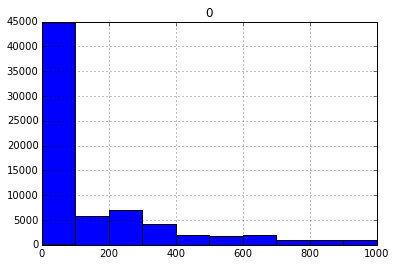

In [37]:
pd.DataFrame(filter(lambda x: x <= 1000,final[202])).hist()

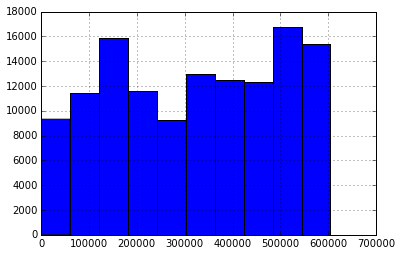

In [45]:
final[209].hist()

In [49]:
final_aug4.shape

(127418, 14)

In [48]:
final[range(486,685)] = pd.DataFrame(final_aug1)

In [50]:
final[range(685,699)] = pd.DataFrame(final_aug4)

In [52]:
final[699] = pd.DataFrame(final_aug2)
final[700] = pd.DataFrame(final_aug3)
final[701] = pd.DataFrame(final_aug5)
final[702] = pd.DataFrame(final_aug6)

In [66]:
final[703] = final[308].map(lambda x : int(x == 0))
final[704] = final[308].map(lambda x : int(x == 1))
final[705] = final[308].map(lambda x : int(x == 2))
final[706] = final[308].map(lambda x : int(x == 3))
final[707] = final[310].map(lambda x : int(x == 0))
final[708] = final[310].map(lambda x : int(x == 1))
final[709] = final[310].map(lambda x : int(x == 2))

In [67]:
save_obj(final, 'final_aug_all')

In [68]:
final.shape

(127418, 710)

In [61]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.4, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300, max_features=700).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [62]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813137654999
0.752443935163
0.870871522317
0.834658766048
0.910369068541
Confusion Matrix: 
[[ 9328  6362]
 [ 3162 32116]]
false positive: 6362
false negative: 3162


In [63]:
from sklearn.preprocessing import OneHotEncoder

In [64]:
final_aug7 = OneHotEncoder().fit_transform(final[308])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [65]:
final_aug7

<1x127418 sparse matrix of type '<type 'numpy.float64'>'
	with 127418 stored elements in Compressed Sparse Row format>

In [ ]:
final

#NEW

In [3]:
final = load_obj('final_aug_all')

In [5]:
indices = range(1, final.shape[1])

data = final[indices]
target = final[0]

In [6]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [7]:
from sklearn.preprocessing import Imputer
imputer = Imputer()
data = imputer.fit_transform(data)

In [8]:
def eval_result():
    # Evaluation
    print "Below are the accuracy, AUC, F1 score, precision, and recall: "
    print clf.score(X_test, y_test)
    print roc_auc_score(y_test, y_pred)
    print f1_score(y_test, y_pred)
    print precision_score(y_test, y_pred)
    print recall_score(y_test, y_pred)

    print "Confusion Matrix: "
    cm = confusion_matrix(y_test, y_pred)
    print cm
    #false positive
    print 'false positive: ' + str(cm[0][1])
    #false negative
    print 'false negative: ' + str(cm[1][0])

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.814589546382
0.754172050777
0.871906091577
0.836115010659
0.910898379971
Confusion Matrix: 
[[ 4678  3152]
 [ 1573 16081]]
false positive: 3152
false negative: 1573


In [11]:
select = SelectKBest(f_classif, k = 600)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [259 322 323 324 325 326 328 338 356 383 397 443 684] are constant.
  UserWarning)


In [12]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [13]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.814314864229
0.753867191123
0.871712844982
0.835950499168
0.910671802424
Confusion Matrix: 
[[ 4675  3155]
 [ 1577 16077]]
false positive: 3155
false negative: 1577


In [14]:
select = SelectKBest(f_classif, k = 500)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)

In [15]:
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.81329461623
0.751069797604
0.871321938555
0.833712866163
0.912484422794
Confusion Matrix: 
[[ 4617  3213]
 [ 1545 16109]]
false positive: 3213
false negative: 1545


In [17]:
select = SelectKBest(f_classif, k = 400)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813569298383
0.752014283067
0.871389513007
0.834499922227
0.911691401382
Confusion Matrix: 
[[ 4638  3192]
 [ 1559 16095]]
false positive: 3192
false negative: 1559


In [18]:
select = SelectKBest(f_classif, k = 300)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813098414692
0.750928186637
0.871169294853
0.833669824507
0.912201200861
Confusion Matrix: 
[[ 4617  3213]
 [ 1550 16104]]
false positive: 3213
false negative: 1550


In [19]:
select = SelectKBest(f_classif, k = 200)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.814393344844
0.753497418304
0.87185739055
0.83554886281
0.911464823836
Confusion Matrix: 
[[ 4663  3167]
 [ 1563 16091]]
false positive: 3167
false negative: 1563


In [20]:
select = SelectKBest(f_classif, k = 100)
data2 = select.fit_transform(data, target)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data2, target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.809252864542
0.744990017422
0.868802461472
0.829767489818
0.911691401382
Confusion Matrix: 
[[ 4528  3302]
 [ 1559 16095]]
false positive: 3302
false negative: 1559


In [28]:
data[:,range(1,304)].shape

(127418, 303)

### with only event feature

In [29]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:,range(1,304)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.813373096845
0.752334624073
0.871146030886
0.834908599917
0.910671802424
Confusion Matrix: 
[[ 4651  3179]
 [ 1577 16077]]
false positive: 3179
false negative: 1577


### with only event + userbase

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:, range(1,449)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

Below are the accuracy, AUC, F1 score, precision, and recall: 
0.81345157746
0.752462337994
0.871193237239
0.834995325647
0.910671802424
Confusion Matrix: 
[[ 4653  3177]
 [ 1577 16077]]
false positive: 3177
false negative: 1577


### with only event + expenditure

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:, range(1,304) + range(449,486)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

### with only event + additional

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:, range(1,304) + range(486,710)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

### with only event + userbase + additional

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:, range(1,499)  + range(486,710)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()

### with only event + expenditure + additional

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[:, range(1,304) + range(449,486) + range(486,710)], target, test_size=0.2, random_state=0)
clf = GradientBoostingClassifier(learning_rate = 0.15, loss='exponential', n_estimators = 300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
eval_result()